## Q. 타이타닉 생존자 예측모델 개발을 위한 Titanic 분석용 데이터셋

#### Titanic data 전처리
- 분석 데이터 : titanic3.csv
- 재사용 가능한 전처리 사용자 함수 작성 하여 전처리
    - Null 값 처리 : Age는 평균나이, 나머지 칼럼은 'N'값으로 변경
    - 불필요한 속성 칼럼 삭제
    - 문자열 칼럼 레이블 인코딩
- 통계적, 시각적 탐색을 통한 다양한 인사이트 도출
- 탐색적 분석을 통한 feature engineering, 파생변수 

#### 컬럼 정보

- survived : 생존여부(1: 생존, 0 : 사망)
- pclass : 승선권 클래스(1 : 1st, 2 : 2nd ,3 : 3rd)
- name : 승객 이름
- sex : 승객 성별
- age : 승객 나이
- sibsp : 동반한 형제자매, 배우자 수
- parch : 동반한 부모, 자식 수
- ticket : 티켓의 고유 넘버
- fare 티켓의 요금
- cabin : 객실 번호
- embarked : 승선한 항구명(C : Cherbourg, Q : Queenstown, S : Southampton)
- boat
- body
- home.dest

## 모델 성능 개선 및 평가

### 데이터셋 개선을 위한 검토사항 예시
* 변수 = 'age_cat','male','female','fare_cat','family',{town_C','town_Q','town_S'}
* age의 Null 값을 평균값으로 대체하면 전체적인 데이터의 왜곡이 심함을 확인
* pclass는 fare_cat이랑 같이 모델에 넣을 경우 정확도가 떨어지고(0.82) 각각 넣었을 때는 fare_cat을 넣었을 때의 정확도가 더 높음(0.82, 3% 차이). 이상치에 가까울 정도로 요금이 높은 사람의 경우 사망률이 3클래스 승객과 비슷한 수치를 보이는 점이 pclass 변수에서는 반영이 되지 않았던 것이 원인으로 추측
* sex, embarked 변수로 집어넣은 것보다 원핫 인코더(dummies)로 처리해서 넣는 것이 정확도를 대략 5% 정도 높여주며 디시전 트리의 분기를 더 쉽게하는 효과 확인
* parch와 sibsp를 각각 변수에 적용하면  의미 있는 양상이 보이지 않고 정확도를 떨어뜨리지만 두 변수를 합쳐서 family라는 파생변수를 생성하면 생존율이 높은 여성 승객일지라도 가족 구성원 수가 많으면 생존율이 낮아지는 것을 확인

### 전처리 내역 예시
- age null 처리방법 변경 : 평균값 대체 > 삭제
- pclass와 fare_cat중 분석변수 선택
- embarked 원핫인코딩

In [41]:
import pandas as pd
titanic_df = pd.read_csv('./dataset/titanic3.csv')
titanic_df.head(2)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"


In [42]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


In [43]:
# age Null값 처리 : mean 대체 vs drop
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
df1 = titanic_df[['age','survived']]
rdf1 = df1.dropna(subset=['age'],how='any',axis=0)
print(rdf1.head())
df1['age'].fillna(df1['age'].mean(),inplace=True)
print(df1.head())

     age  survived
0  29.00         1
1   0.92         1
2   2.00         0
3  30.00         0
4  25.00         0
     age  survived
0  29.00         1
1   0.92         1
2   2.00         0
3  30.00         0
4  25.00         0


Text(0.5, 1.0, 'age_mean')

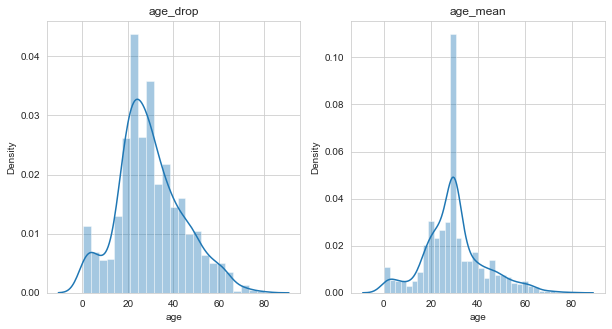

In [44]:
# 히스토그램/커널 밀도 그래프
# 커널 밀도 함수는 그래프와 x축 사이의 면적이 1이 되도록 그리는 밀도 분포 함수
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style('whitegrid')
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
sns.distplot(rdf1.age,ax=ax1)
sns.distplot(df1.age,ax=ax2)

ax1.set_title('age_drop')
ax2.set_title('age_mean')

In [48]:
titanic_df.embarked.value_counts()

S    916
C    270
Q    123
Name: embarked, dtype: int64

In [46]:
titanic_df['embarked'].value_counts(dropna=True).idxmax()

'S'

In [45]:
# 전처리 사용자함수

def fillna(df):
    df['age'] = df1['age'].fillna(df1['age'].mean())
    most_town = df['embarked'].value_counts(dropna=True).idxmax()
    df['embarked'].fillna(most_town, inplace=True)
    df['fare'].fillna(df['fare'].mean(), inplace=True)    
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거(PassengerId, Name, Ticket)
def drop_features(df):
    df.drop(['name', 'cabin','ticket','body','home.dest','boat'], axis=1,inplace=True)
    return df

def transform_features(df):    
    df = fillna(df)
    df = drop_features(df)
    return df
titanic_df = transform_features(titanic_df)
titanic_df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1,1,female,29.00,0,0,211.3375,S
1,1,1,male,0.92,1,2,151.5500,S
2,1,0,female,2.00,1,2,151.5500,S
3,1,0,male,30.00,1,2,151.5500,S
4,1,0,female,25.00,1,2,151.5500,S


In [50]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1309 non-null   int64  
 1   survived  1309 non-null   int64  
 2   sex       1309 non-null   object 
 3   age       1309 non-null   float64
 4   sibsp     1309 non-null   int64  
 5   parch     1309 non-null   int64  
 6   fare      1309 non-null   float64
 7   embarked  1309 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 81.9+ KB


In [52]:
titanic_df.fare.value_counts()

8.0500     60
13.0000    59
7.7500     55
26.0000    50
7.8958     49
           ..
31.6833     1
25.7417     1
9.4833      1
15.0333     1
32.3208     1
Name: fare, Length: 282, dtype: int64

In [51]:
titanic_df.fare.describe()

count    1309.000000
mean       33.295479
std        51.738879
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: fare, dtype: float64

<AxesSubplot:xlabel='fare', ylabel='Count'>

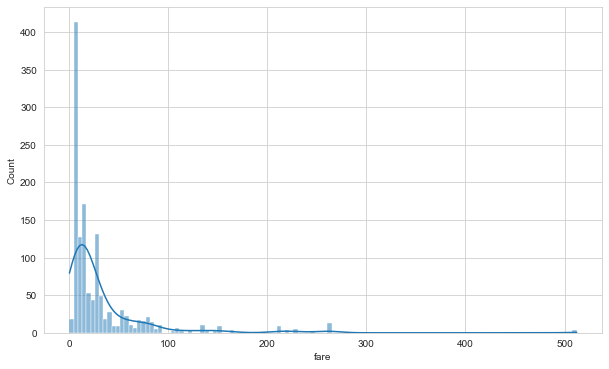

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
# titanic_df.fare.plot(kind='hist')
fig = plt.figure(figsize=(10,6))
sns.histplot(titanic_df.fare, kde=True)

In [54]:
# fare_cat 파생변수
def fare_cat(f):
    cat = ''
    if f <= 10: cat = 4
    elif f <= 40: cat = 3
    elif f <= 100: cat = 2
    else: cat = 1
    return cat

titanic_df['fare_cat'] = titanic_df['fare'].apply(lambda x: fare_cat(x))

In [55]:
titanic_df.age.value_counts()

29.881138    263
24.000000     47
22.000000     43
21.000000     41
30.000000     40
            ... 
23.500000      1
11.500000      1
67.000000      1
0.330000       1
60.500000      1
Name: age, Length: 99, dtype: int64

<AxesSubplot:xlabel='age', ylabel='Count'>

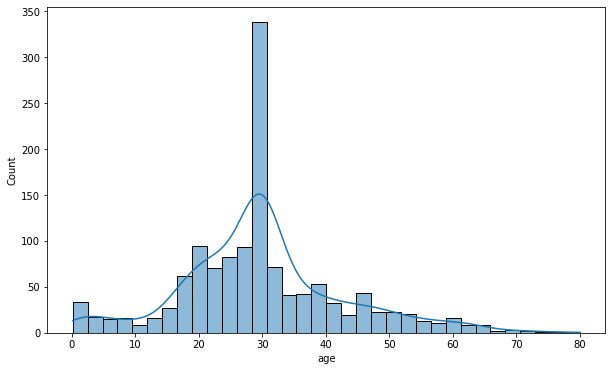

In [22]:
fig = plt.figure(figsize=(10,6))
sns.histplot(titanic_df.age,kde=True)

In [56]:
def get_cat(age):
    cat = ''
    if age <= 10: cat = 'young'
    elif age <= 20: cat = 'teen'
    elif age <= 30: cat = 'adult'
    elif age <= 60: cat = 'mature'
    else: cat = 'elder'
    return cat

titanic_df['age_cat'] = titanic_df['age'].apply(lambda x: get_cat(x))

In [57]:
titanic_df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked,fare_cat,age_cat
0,1,1,female,29.00,0,0,211.3375,S,1,adult
1,1,1,male,0.92,1,2,151.5500,S,1,young
2,1,0,female,2.00,1,2,151.5500,S,1,young
3,1,0,male,30.00,1,2,151.5500,S,1,adult
4,1,0,female,25.00,1,2,151.5500,S,1,adult


<AxesSubplot:xlabel='age_cat', ylabel='count'>

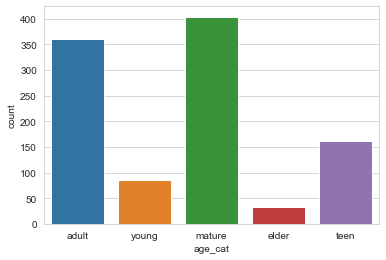

In [31]:
sns.countplot('age_cat',data=titanic_df)

In [58]:
# 패밀리 변수 만들기
titanic_df['family'] = titanic_df['sibsp'] + titanic_df['parch']
titanic_df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked,fare_cat,age_cat,family
0,1,1,female,29.00,0,0,211.3375,S,1,adult,0
1,1,1,male,0.92,1,2,151.5500,S,1,young,3
2,1,0,female,2.00,1,2,151.5500,S,1,young,3
3,1,0,male,30.00,1,2,151.5500,S,1,adult,3
4,1,0,female,25.00,1,2,151.5500,S,1,adult,3


In [59]:
# embarked onehot encoding : sex, embarked

onehot_sex = pd.get_dummies(titanic_df['sex'])
onehot_embarked = pd.get_dummies(titanic_df['embarked'], prefix='town')
titanic_df = pd.concat([titanic_df,onehot_sex,onehot_embarked], axis=1)
titanic_df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked,fare_cat,age_cat,family,female,male,town_C,town_Q,town_S
0,1,1,female,29.00,0,0,211.3375,S,1,adult,0,1,0,0,0,1
1,1,1,male,0.92,1,2,151.5500,S,1,young,3,0,1,0,0,1
2,1,0,female,2.00,1,2,151.5500,S,1,young,3,1,0,0,0,1
3,1,0,male,30.00,1,2,151.5500,S,1,adult,3,0,1,0,0,1
4,1,0,female,25.00,1,2,151.5500,S,1,adult,3,1,0,0,0,1


In [30]:
titanic_df.fare_cat.value_counts()

3    554
4    491
2    180
1     84
Name: fare_cat, dtype: int64

In [60]:
#  전처리 사용자 함수 
from sklearn.preprocessing import LabelEncoder

def label_encoding(df):
    le = LabelEncoder()
    df.age_cat = le.fit_transform(df.age_cat)
    return df
    
def drop_feature(df):
    df.drop(['age','fare','sex','sibsp','pclass','parch','embarked'],axis=1,inplace=True)
    return df

def transform_features(df):
    df = label_encoding(df)
    df = drop_feature(df)
    return df

titanic_df = transform_features(titanic_df)
titanic_df.head()

,survived,fare_cat,age_cat,family,female,male,town_C,town_Q,town_S
0,1,1,0,0,1,0,0,0,1
1,1,1,4,3,0,1,0,0,1
2,0,1,4,3,1,0,0,0,1
3,0,1,0,3,0,1,0,0,1
4,0,1,0,3,1,0,0,0,1


In [61]:
# 분석용 데이터 셋
titanic_df.to_pickle('dataset/tdf.pkl')

In [62]:
# titanic_df.to_pickle('dataset/tdf.pkl')
titanic_df = pd.read_pickle('dataset/tdf.pkl')
titanic_df.head()

,survived,fare_cat,age_cat,family,female,male,town_C,town_Q,town_S
0,1,1,0,0,1,0,0,0,1
1,1,1,4,3,0,1,0,0,1
2,0,1,4,3,1,0,0,0,1
3,0,1,0,3,0,1,0,0,1
4,0,1,0,3,1,0,0,0,1


In [35]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# 독립변수, 종속변수 분리
y_t_df = titanic_df['survived'] # 종속변수
X_t_df = titanic_df.drop('survived', axis = 1) # 독립변수

# 독립변수 정규화
# X_t_df = preprocessing.StandardScaler().fit(X_t_df).transform(X_t_df)

# 학습용 데이터와 평가용 데이터를 8:2 혹은 7:3으로 분리
X_train, X_test, y_train, y_test = train_test_split(X_t_df, y_t_df, test_size = 0.2,
                                                   random_state = 11)

print(X_train.shape)
print(X_test.shape)


(1047, 8)
(262, 8)


In [63]:
# 모델 학습 및 평가
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, rf_pred).round(2)

lr_model = LogisticRegression()
lr_model.fit(X_train,y_train)
lr_pred = lr_model.predict(X_test)
accuracy_lr = accuracy_score(y_test,lr_pred).round(2)

print('rf 정확도:{}, lr 정확도:{}'.format(accuracy_rf,accuracy_lr))

rf 정확도:0.77, lr 정확도:0.81
